# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

# Readme


這份作業的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

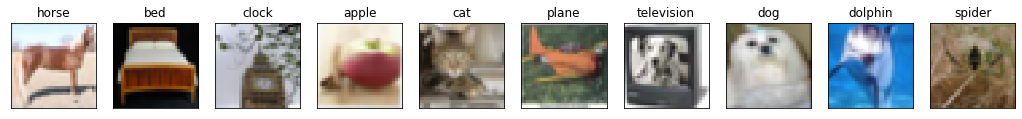

In [1]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

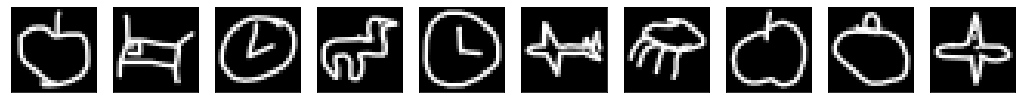

In [2]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

<ipython-input-3-6a76aae1b4d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 5, 2)


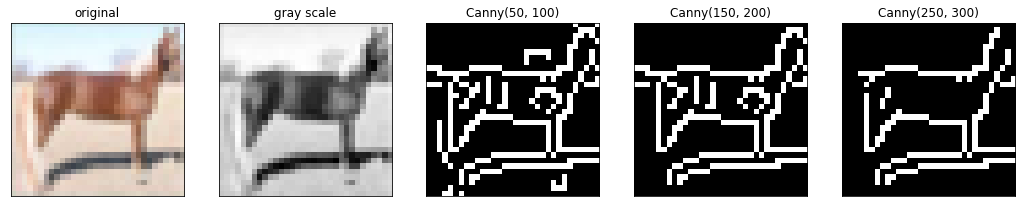

In [3]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size= 128, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size= 128, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size = 32, shuffle=False)

# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [5]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [6]:
class EMA:
    def __init__(self, decay):
        self.decay = decay
        self.shadow = {}

    def register(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
        self.params = self.shadow.keys()

    def __call__(self, model):
        if self.decay > 0:
            for name, param in model.named_parameters():
                if name in self.params and param.requires_grad:
                    self.shadow[name] -= (1 - self.decay) * (self.shadow[name] - param.data)
                    param.data = self.shadow[name]

In [7]:
class WeightEMA (object):
    def __init__(self, params, src_params, alpha=0.998):

        self.params = list(params)
        self.src_params = list(src_params)
        self.alpha = alpha

        for p, src_p in zip(self.params, self.src_params):
            p.data[:] = src_p.data[:]

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for p, src_p in zip(self.params, self.src_params):
            p.data.mul_(self.alpha)
            p.data.add_(src_p.data * one_minus_alpha)

    def zero_grad(self):
        pass


In [8]:
class ConditionalEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(ConditionalEntropyLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = b.sum(dim=1)
        return -1.0 * b.mean(dim=0)

In [9]:
class VATLoss(nn.Module):
    """
    We define a function of regularization, specifically VAT.
    """

    def __init__(self, model):
        super(VATLoss, self).__init__()
        self.model = model
        self.kl_div = nn.KLDivLoss(size_average=False, reduce=False).to(device)

    def forward(self, X , logit):
        vat_loss = virtual_adversarial_loss(X, logit , self.model, self.kl_div)
        return vat_loss  # already averaged


def kl_divergence_with_logit(q_logit, p_logit):
    q = F.softmax(q_logit, dim=1)
    qlogq = torch.mean(torch.sum(q * F.log_softmax(q_logit, dim=1), dim=1))
    qlogp = torch.mean(torch.sum(q * F.log_softmax(p_logit, dim=1), dim=1))
    return qlogq - qlogp


def get_normalized_vector(d):
    return F.normalize(d.view(d.size(0), -1), p=2, dim=1).reshape(d.size())

def generate_virtual_adversarial_perturbation(x, model):
    d = torch.randn_like(x)
#     for _ in range(n_power):
#         d = get_normalized_vector(d).requires_grad_()
#         #d = XI * get_normalized_vector(d).requires_grad_()
#         logit_m = model(x + d)
#         dist = kl_divergence_with_logit(logit, logit_m)
#         grad = torch.autograd.grad(dist, [d])[0]
#         d = grad.detach()
#     return get_normalized_vector(d)
    return get_normalized_vector(d).requires_grad_()
    #return epsilon * get_normalized_vector(d)


def virtual_adversarial_loss(x,logit, model , kl_div):
    r_vadv = generate_virtual_adversarial_perturbation(x, model)
    prob_logits = F.softmax(logit.detach(), dim=1)
    logit_m = model(x + r_vadv)
    loss = torch.mean(kl_div(
            F.log_softmax(logit_m, dim=1), prob_logits).sum(dim=1))
    return loss

# Pre-processing

這裡我們選用Adam來當Optimizer。

# Start Training


## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式，畢竟GAN是之前的作業，應該會比較熟悉:)。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

In [10]:
def train_epoch(target_dataloader):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    teacher.eval()
    student.train()
    kl_div = nn.KLDivLoss(size_average=False, reduce=False).to(device)
    
    for i, (target_data, _) in enumerate (target_dataloader):
        target_data = target_data.cuda()

        # Step 2 : train feature extractor and label classifier
        beta_t = 1e-2
        lamb_t = 1e-2
        
        target_logits = teacher(target_data)
        prob_logits = F.softmax(target_logits.detach(), dim=1)
        #student.eval()
        target_logits_student = student(target_data)
        loss_t = lamb_t * (vat_loss(target_data , target_logits_student) + cent(target_logits_student))
        #student.train()
        kl_div_ = beta_t * torch.mean(kl_div(F.log_softmax(target_logits_student, dim=1), prob_logits).sum(dim =1))
        loss = loss_t + kl_div_
        running_F_loss+= loss.item()
        
        loss.backward()
        optimizer_S.step()
        scheduler.step()
        optimizer_S.zero_grad()
        #ema(student)
        #optimizer_T.step()
        print(i, end='\r')
        
    #torch.save(feature_extractor_teacher.state_dict(), f'extractor_model_teacher.bin')
    torch.save(feature_extractor_student.state_dict(), f'extractor_model_student.bin')
    #torch.save(label_predictor_teacher.state_dict(), f'predictor_model_teacher.bin')
    torch.save(label_predictor_student.state_dict(), f'predictor_model_student.bin')
    return  running_F_loss / (i+1)

def inference(epoch):
    result = []
    student.eval()
    for i, (test_data, _) in enumerate(test_dataloader):
        test_data = test_data.cuda()

        class_logits = student(test_data)

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)

    import pandas as pd
    result = np.concatenate(result)

    # Generate your submission
    tmp = './dirt/result_' + str(epoch) +'_dirt.csv'
    df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
    df.to_csv(tmp,index=False)
    student.train()

    
 

In [ ]:
learning_rate = 1e-3
#Teacher
feature_extractor_teacher = FeatureExtractor().cuda()
feature_extractor_teacher.load_state_dict(torch.load('extractor_model_vada_v3_79.bin'))
label_predictor_teacher = LabelPredictor().cuda()
label_predictor_teacher.load_state_dict(torch.load('predictor_model_vada_v3_79.bin'))
teacher = nn.Sequential(feature_extractor_teacher , label_predictor_teacher)
teacher.eval()
#Student
feature_extractor_student = FeatureExtractor().cuda()
feature_extractor_student.load_state_dict(torch.load('extractor_model_vada_v3_79.bin'))
label_predictor_student = LabelPredictor().cuda()
label_predictor_student.load_state_dict(torch.load('predictor_model_vada_v3_79.bin'))
student = nn.Sequential(feature_extractor_student , label_predictor_student)
student.train()
#domain_classifier = DomainClassifier().cuda()
 
#ema = EMA(0.998)
#ema.register(student)
#Optimizer and Scheduler
#student_params   = list(student.parameters())
#teacher_params   = list(teacher.parameters())

#for param in teacher_params:
 #   param.requires_grad = False
cent = ConditionalEntropyLoss()
vat_loss = VATLoss(student)
optimizer_S = optim.Adam(student.parameters() , lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_S , T_max = 500)
#optimizer_T =  WeightEMA(teacher_params, student_params)
#optimizer_D = optim.Adam(domain_classifier.parameters() , lr = learning_rate)    

#class_criterion = nn.CrossEntropyLoss()
#domain_criterion = nn.BCEWithLogitsLoss()

total_epoch = 101
# train 200 epochs
for epoch in range(total_epoch):
    # You should chooose lamnda cleverly.
    #lamb_d = 2/(1 + np.exp(-10 * epoch / total_epoch) - 1
    if epoch != 0 :
        feature_extractor_teacher = FeatureExtractor().cuda()
        feature_extractor_teacher.load_state_dict(torch.load('extractor_model_student.bin'))
        label_predictor_teacher = LabelPredictor().cuda()
        label_predictor_teacher.load_state_dict(torch.load('predictor_model_student.bin'))
        teacher = nn.Sequential(feature_extractor_teacher , label_predictor_teacher)
        teacher.eval()
    loss = train_epoch(target_dataloader)
    #if (epoch % 10 == 0 and epoch != 0) or epoch == 99:
    if epoch!=0 and epoch % 10 == 0:
        inference(epoch)
    print('epoch {:>3d}: train F loss: {:6.4f}'.format(epoch , loss))

C:\Users\mark0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch   0: train F loss: 0.0012
epoch   1: train F loss: 0.0010
epoch   2: train F loss: 0.0009
epoch   3: train F loss: 0.0009
epoch   4: train F loss: 0.0008
epoch   5: train F loss: 0.0008
epoch   6: train F loss: 0.0008
epoch   7: train F loss: 0.0008
epoch   8: train F loss: 0.0007
epoch   9: train F loss: 0.0007
epoch  10: train F loss: 0.0007


C:\Users\mark0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch  11: train F loss: 0.0007
epoch  12: train F loss: 0.0007
epoch  13: train F loss: 0.0007
epoch  14: train F loss: 0.0006
epoch  15: train F loss: 0.0006
epoch  16: train F loss: 0.0006
epoch  17: train F loss: 0.0006
epoch  18: train F loss: 0.0006
epoch  19: train F loss: 0.0006
epoch  20: train F loss: 0.0006
epoch  21: train F loss: 0.0006
epoch  22: train F loss: 0.0006
epoch  23: train F loss: 0.0006
epoch  24: train F loss: 0.0006
epoch  25: train F loss: 0.0006
epoch  26: train F loss: 0.0006
epoch  27: train F loss: 0.0006
epoch  28: train F loss: 0.0006
epoch  29: train F loss: 0.0006
epoch  30: train F loss: 0.0006
epoch  31: train F loss: 0.0006
epoch  32: train F loss: 0.0006
epoch  33: train F loss: 0.0006
epoch  34: train F loss: 0.0005
epoch  35: train F loss: 0.0005
epoch  36: train F loss: 0.0005
epoch  37: train F loss: 0.0005
epoch  38: train F loss: 0.0005
epoch  39: train F loss: 0.0005
epoch  40: train F loss: 0.0005
epoch  41: train F loss: 0.0005
epoch  4

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [ ]:
'''
feature_extractor = FeatureExtractor().cuda()
feature_extractor.load_state_dict(torch.load('extractor_model.bin'))
label_predictor = LabelPredictor().cuda()
label_predictor.load_state_dict(torch.load('predictor_model.bin'))
'''



# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
